In [1]:
import numpy as np
import scipy.linalg

import pyemma

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab


In [106]:
class HummerCG(object):
    
    def __init__(self,msm,grps):
        """
        coarse-grains micro msm using groups 
        """
        
        pi_micro = msm.pi
        T = msm.P
        
        ## prep aggregation matrix
        n_cg = len(grps)
        n_micro = len(np.concatenate(grps))
        assert T.shape == (n_micro,n_micro) 
        assert len(pi_micro)== n_micro
        A = np.zeros((n_micro,n_cg))
        for i,grp in enumerate(grps):
            A[np.array(grp),i] = 1
        
        pi_cg = np.dot(pi_micro,A)
        #print(A)
        assert np.abs(pi_micro.sum() - pi_cg.sum())< 1.e-9
        
        ## calc cg matrix (eq. 25b)
        P1_micro = np.dot(pi_micro.reshape((n_micro,1)),np.ones((1,n_micro)))
        D_micro = np.diag(pi_micro)
        P1_cg = np.dot(pi_cg.reshape((n_cg,1)),np.ones((1,n_cg)))
        D_cg = np.diag(pi_cg)
        
        aux1 = np.linalg.inv(np.eye(n_micro) + P1_micro - T)
        aux2a = np.dot(np.transpose(A), aux1)
        aux2b = np.dot(D_micro,A)
        aux3 = np.linalg.inv(np.dot(aux2a,aux2b))
        R = np.eye(n_cg) + P1_cg - np.dot(D_cg,aux3)
        
        self.pi_cg = pi_cg
        self.T_cg = R
        self.aggregation_matrix = A
        self.msm_micro = msm
        self.pi_micro = msm.pi
        self.T = msm.P
        
    def plot_timescales(self,i, tau=1):
        """
        plots cg timescales and micro timescales
        """
        from msmtools.analysis import eigenvalues as anaeig

        
        ts_micro = self.msm_micro.timescales(i)
        R = self.T_cg

        lambdas_cg = anaeig(R,k=i)
        if np.all(lambdas_cg.imag == 0):
            lambdas_cg = lambdas_cg.real
        #print(lambdas_cg)
        
        ind_perron = np.isclose(np.abs(lambdas_cg), 1.0, rtol=0.0, atol=1e-14)
        assert sum(ind_perron) <= 1
        ts = np.zeros(len(lambdas_cg))

        tau_cg = -1/np.log(np.abs(lambdas_cg))
        plt.plot(ts_micro,'--x',label='micro')
        plt.plot(tau_cg[1:],'-o',label='cg')
        plt.legend()
        plt.show()
        
    def cg_relaxation_from_state_to_state(self,i_cg,j_cg,nmax=50):
        
        def _relaxation(T,p0,a,nmax):
            """relaxes p0 using T, and returns expectation of observable a"""
            p = p0
            rel = []
            occ = []
            for time in range(nmax):
                rel.append(np.dot(p,a))
                occ.append(p)
                p = np.dot(T,p)
            return np.array(range(nmax)),np.array(rel),np.array(occ)
        
        p0_cg = np.zeros_like(self.pi_cg)
        p0_cg[i_cg]=1
        #print(p0_cg)
        #print(self.T_cg)
        ind_final_cg = np.zeros_like(self.pi_cg)
        ind_final_cg[j_cg] = 1
        print("ind_final_cg", ind_final_cg)
        time_cg,rel_cg,occ_cg = _relaxation(self.T_cg,p0_cg,a=ind_final_cg,nmax=nmax)
        
        # initial prob in micro, according to local equilibrium in cg state=0
        A_cg = self.aggregation_matrix
        pi0_micro = A_cg[:,i_cg]*self.pi_micro
        pi0_micro = pi0_micro/pi0_micro.sum()
        ind_final_micro = A_cg[:,j_cg]
        time_micro,rel_micro,occ_micro = _relaxation(self.T,pi0_micro,a=ind_final_micro,nmax=nmax)

        plt.plot(time_micro,rel_micro,'x',label='micro')
        plt.plot(time_cg,rel_cg,'-o',label='macro')
        plt.legend()
        plt.show()
        
        return time_cg,rel_cg,occ_cg 
        

In [75]:
## define model transition matrix for testing
def Kmod(k,h):
    S=np.array([[0,k,0,0],[k,0,h,0],[0,h,0,k],[0,0,k,0]])
    return S - np.diag(S.sum(axis=1))

T_micro = scipy.linalg.expm(Kmod(k=1,h=5)*0.1)


## define the two cg choices in the paper example
grps1 = [np.array([0,1]),np.array([2,3])]
grps2 = [np.array([0]),np.array([1,2]),np.array([3])]


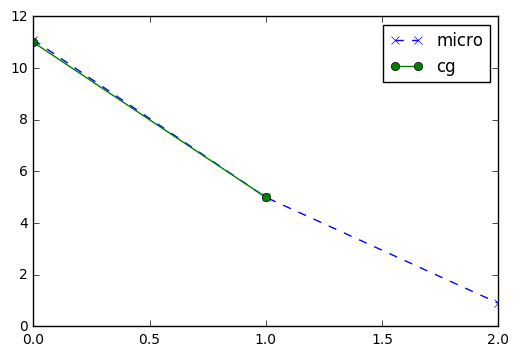

In [76]:
## define the microscopic model and cg it
msm_micro = pyemma.msm.markov_model(T_micro)

cg = HummerCG(msm_micro,grps2)
cg.plot_timescales(3)

('ind_final_cg', array([ 1.,  0.,  0.,  0.,  0.,  0.]))


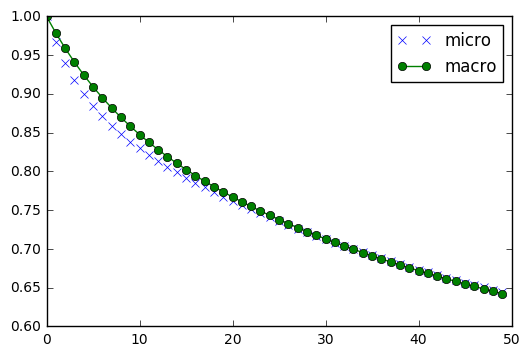

In [144]:
cg.cg_relaxation_from_state_to_state(0,0);


In [30]:
import numpy as np
import itertools
import pyemma
from pyemma import msm
import warnings
warnings.filterwarnings('ignore')

In [31]:
import pyemma.plots as mplt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [32]:
def trans_matrix(n,m):
    t= np.zeros((n+m,n+m))

    for i,j in itertools.product(range(n),range(n)):
        if abs(i-j)==1:
            t[i,j]=10 # diffusional rate1
        
    for i,j in itertools.product(range(n,n+m),[n-1]):
        t[i,j]=2 #rate2
        t[j,i]=1 #rate3
    
    np.fill_diagonal(t,100.-t.sum(axis=1))
    tm = t/t.sum(axis=1)
    return tm

In [153]:

n=4
m=4
tm = trans_matrix(n,m)
mm=msm.markov_model(tm)
mm.stationary_distribution

array([ 0.16666667,  0.16666667,  0.16666667,  0.16666667,  0.08333333,
        0.08333333,  0.08333333,  0.08333333])

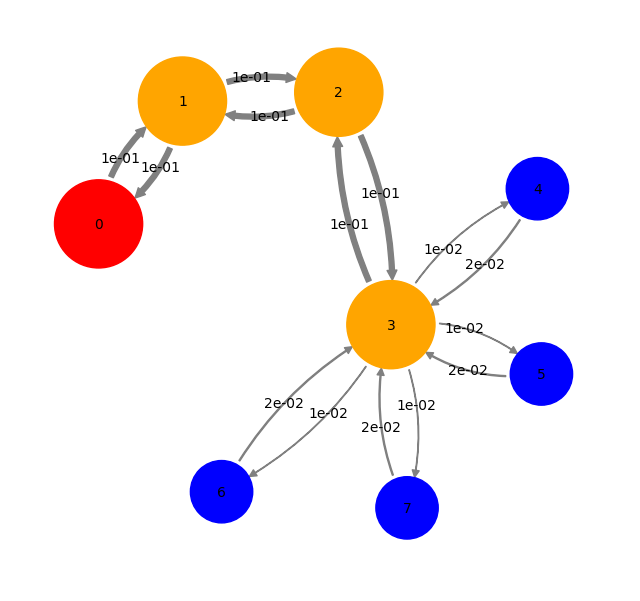

In [154]:
cols=['red']+(n-1)*['orange']+m*['blue']
dummy =mplt.plot_markov_model(mm,state_colors = cols,
                       max_width=8, max_height=8)

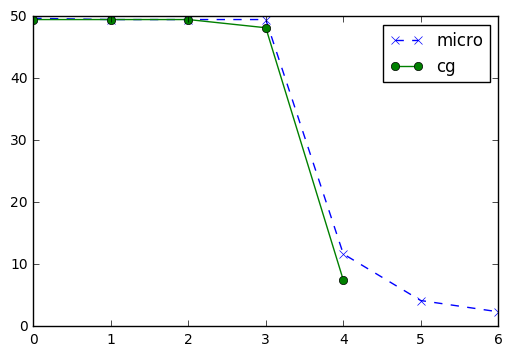

In [162]:
grp = [[0,1,2], [3] ,[4],[5],[6],[7]]
cg = HummerCG(mm,grp)
cg.plot_timescales(10)

In [166]:
mm.mfpt(A=grp[0],B=grp[2])

596.66666666667243

In [167]:
import msmtools
msmtools.analysis.mfpt(cg.T_cg,0,2)

96.666666666667652

('ind_final_cg', array([ 0.,  0.,  1.,  0.,  0.,  0.]))


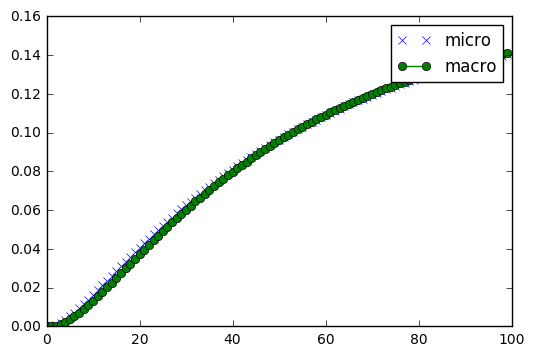

In [169]:
cg.cg_relaxation_from_state_to_state(0,2,100);

In [135]:
pyemma.__version__

u'2.2.7'

In [120]:
nangle=9
ndist=3
angle =np.linspace(0,2*np.pi*(1-1./nangle),nangle)
da = angle[1]-angle[0]


dist = np.linspace(1,10,ndist)
dd = dist[1]-dist[0]
grid1 = itertools.product(list(angle),list(dist))
stat = [item for item in grid1]

nbound = 2
to_b= np.ceil(np.linspace(1e-4,1,len(angle))*(nbound))-1

M=np.zeros((len(stat)+nbound,len(stat)+nbound))

for i,oi in enumerate(stat):
    for j,oj in enumerate(stat):
        if i!=j:
            if (abs(oi[1]-oj[1])<1e-4) and \
            (abs(oi[0]-oj[0])-da<1e-4 or abs(oi[0]-oj[0]-2*np.pi)-da<1e-4): 
                #print(oi,oj)
                #and abs(oi[0]-oj[0])==2*pi/(5-1) and abs(oi[1]-oj[1])==10/(5-1):
                M[i,j]=5.
                M[j,i]=5.
                #print(oi,oj)
            if abs(oi[0]-oj[0])==0 and abs(oi[1]-oj[1])==dd:
                M[i,j]=5.
                M[j,i]=5.
                #print(oi,oj)

for i,oi in enumerate(stat):
    anindex = np.where(angle==oi[0])[0][0]
    offset = len(stat)
    if(oi[1]==dist[0]):
        #print(i,oi,offset+to_b[anindex] )
        M[i,offset+to_b[anindex]]=5.
        M[offset+to_b[anindex],i]=2.

    
np.fill_diagonal(M,3500.-M.sum(axis=1))
tm3 = M/M.sum(axis=1)
assert np.all(tm3.sum(axis=1)==1)

In [121]:
mm3=msm.markov_model(tm3)

In [122]:
outer = dist[-1]+3
pos = [[np.cos(s[0])*(outer-s[1]),np.sin(s[0])*(outer-s[1])] 
       for s in stat] + [
    [np.cos(angle[to_b==s].mean())*(outer+4),
     np.sin(angle[to_b==s].mean())*(outer+4)] 
    for s in range(nbound)]

In [48]:
#qq=mplt.plot_markov_model(mm3, pos = np.array(pos),
#                      max_width=8, max_height=8,arrow_labels=None)

In [123]:
grps = [[28],[27],[12,15,18,21,24],[9,6,3,0]]
bulk = np.setdiff1d(range(28),np.concatenate(grps))
grps0 = grps + [list(bulk)]

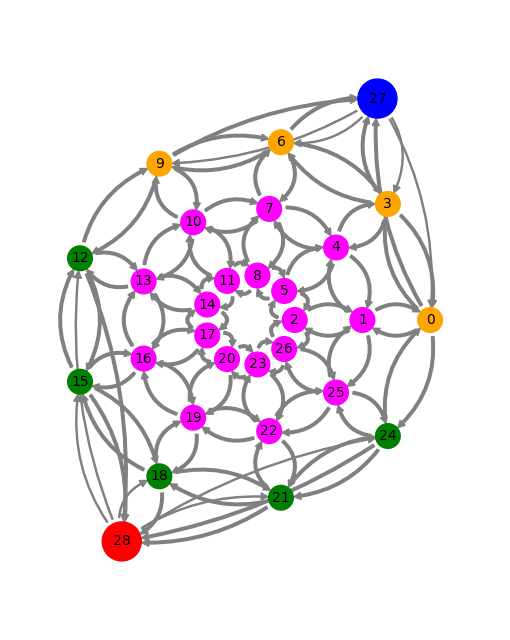

In [124]:
states_comm = np.empty(29)
for i,grp in enumerate(grps0):
    states_comm[np.array(grp)]=i
states_comm = states_comm.astype('int')
col1=np.array(['red','blue','green','orange','magenta','cyan'])[states_comm]

qq=mplt.plot_markov_model(mm3, pos = np.array(pos), state_colors=col1,
                      max_width=8, max_height=8,arrow_labels=None)

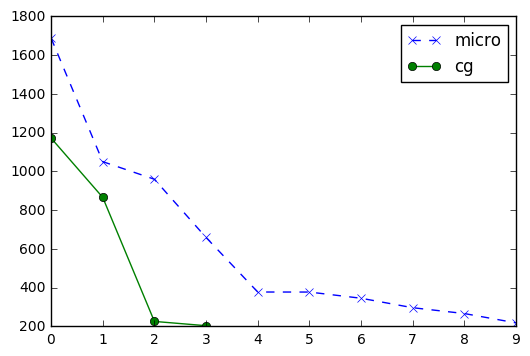

In [125]:
cg = HummerCG(mm3,grps0)
cg.plot_timescales(10)

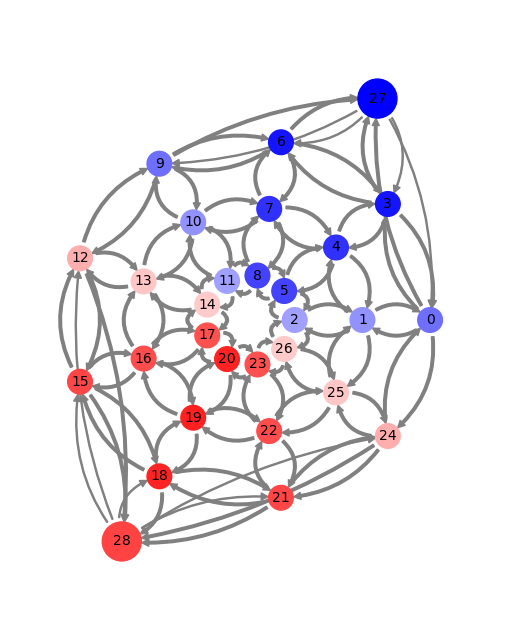

In [126]:
eigv = mm3.eigenvectors_right()[:,1]
cscale = 0.5+0.5*eigv/np.max(np.abs(eigv))
cols = [matplotlib.colors.rgb2hex(plt.cm.bwr(c)) for c in cscale]
qq=mplt.plot_markov_model(mm3, pos = np.array(pos), state_colors=cols,
                      max_width=8, max_height=8,arrow_labels=None)

('ind_final_cg', array([ 0.,  0.,  0.,  1.,  0.]))


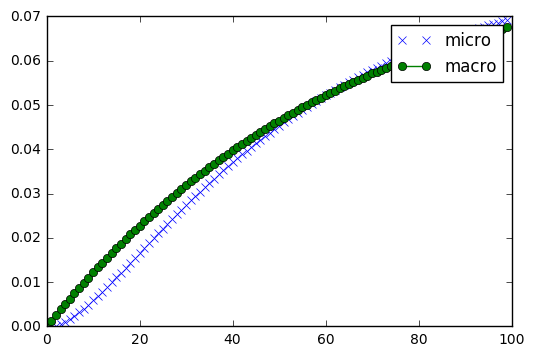

In [149]:
cg.cg_relaxation_from_state_to_state(1,3,100);